In [18]:
import numpy as np
from pathlib import Path
import os
from osgeo import gdal
from skimage.util.shape import view_as_windows
import imageio
from tqdm import tqdm
import torch.nn.functional as F

/home/thiago/python-envs/base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [55]:
def load_tif_image(tif_path):
    gdal_header = gdal.Open(str(tif_path))
    return gdal_header.ReadAsArray()

tif_path = '/home/thiago/AmazonDeforestation_Prediction/AmazonData/Dataset_Felipe/test.tif'
# 0-12->2020, 13-22->2021, 23-36-> 2022
img_test = load_tif_image(tif_path)
img_test = img_test.reshape((3, -1, img_test.shape[1], img_test.shape[2])).max(axis=0)
img_test = img_test
print(img_test.shape)
#TODO: Tentar usar a imagem expandida
# img_test = img_test[:, :2304, :2944]
new_img_test = np.ones((img_test.shape[0], (img_test.shape[1] // 64 + 1) * 64, (img_test.shape[2] // 64 + 1) * 64)) * -1
new_img_test[:, :img_test.shape[1], :img_test.shape[2]] = img_test
# img_test = img_test[:, ]

(12, 2332, 3004)


In [19]:
def extract_sorted_patches(img, patch_size):
    '''Extract sorted patches with no overlap, i.g, stride equal to patch_size'''
    stride = patch_size

    temp, height, width = img.shape

    num_patches_h = int(height / stride)
    num_patches_w = int(width / stride)

    new_shape = (num_patches_h*num_patches_w, temp, patch_size, patch_size)
    patches = np.zeros(new_shape)
    
    cont = 0
    for h in range(num_patches_h):
        for w in range(num_patches_w):
            patches[cont] = img[:, h*stride:(h+1)*stride, w*stride:(w+1)*stride]
            cont += 1
    return patches

def patches_reconstruction(patches, patch_size, original_shape):
    '''Reconstruct an image from a set of patches systematically extracted and no overlap'''
    stride = patch_size

    num_patches_h = original_shape[1] // stride
    num_patches_w = original_shape[2] // stride

    assert(num_patches_h * num_patches_w) == patches.shape[0], "Number of patches didn't match"
    
    img_reconstructed = np.zeros(original_shape)
    cont = 0
    for h in range(num_patches_h):
        for w in range(num_patches_w):
            img_reconstructed[:, h*stride:(h+1)*stride, w*stride:(w+1)*stride] = patches[cont, :]
            cont += 1
    print('Reconstruction Done!')
    return img_reconstructed

In [8]:
def extract_sorted_patches2(img, patch_size, window_size=5):
    '''Extract sorted patches windowed with no overlap, i.g, stride equal to patch_size'''
    stride = patch_size

    temp, height, width = img.shape

    num_patches_h = int(height / stride)
    num_patches_w = int(width / stride)
    
    # cont = 0
    patches = []
    total_iterations = (num_patches_h*num_patches_w) * (temp - window_size + 1)
    with tqdm(total=total_iterations, desc='Test:Extracting Patches') as pbar:
        for h in range(num_patches_h):
            for w in range(num_patches_w):
                patch = img[:, h*stride:(h+1)*stride, w*stride:(w+1)*stride]
                windowed_patches = []
                print(patch.shape[0] - window_size + 1)
                for j in range(patch.shape[0] - window_size + 1):
                    windowed_patch = patch[j:j+window_size]
                    windowed_patches.append(windowed_patch)
                    pbar.update(1)
                patches.append(np.stack(windowed_patches, axis=0))
                
    return np.stack(patches, axis=0)

def patches_reconstruction2(patches, patch_size, original_shape):
    '''Reconstruct an image from a set of windowed patches systematically extracted and no overlap'''
    stride = patch_size

    temp, height, width = original_shape
    
    num_patches_h = original_shape[1] // stride
    num_patches_w = original_shape[2] // stride

    print(num_patches_h * num_patches_w, patches.shape[0])
    assert(num_patches_h * num_patches_w) == patches.shape[0], "Number of patches didn't match"
    
    img_reconstructed = np.zeros((patches.shape[1], height, width))
    cont = 0
    for h in range(num_patches_h):
        for w in range(num_patches_w):
            for j in range(patches.shape[1]):
                img_reconstructed[j, h*stride:(h+1)*stride, w*stride:(w+1)*stride] = patches[cont, j, -1]
            cont += 1
    print('Reconstruction Done!')
    return img_reconstructed

In [58]:
# new_img_test = new_img_test[2:]
patches = extract_sorted_patches2(new_img_test, patch_size=64)
print(patches.shape)
patches = patches.reshape(-1, patches.shape[2], patches.shape[3], patches.shape[4])
print(patches.shape)

Test:Extracting Patches:   9%|▉         | 931/10434 [00:00<00:01, 9293.50it/s]

6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


Test:Extracting Patches:  26%|██▌       | 2666/10434 [00:00<00:01, 7558.65it/s]

6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


Test:Extracting Patches:  42%|████▏     | 4363/10434 [00:00<00:00, 8134.54it/s]

6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


Test:Extracting Patches:  60%|██████    | 6283/10434 [00:00<00:00, 8910.39it/s]

6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


Test:Extracting Patches:  79%|███████▉  | 8263/10434 [00:00<00:00, 9393.86it/s]

6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


Test:Extracting Patches: 100%|██████████| 10434/10434 [00:01<00:00, 8692.42it/s]

6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


(1739, 6, 5, 64, 64)
(10434, 5, 64, 64)


In [96]:
img_test_rec2 = patches_reconstruction2(patches.reshape(-1, 7, 5, 64, 64), patch_size=64, original_shape=new_img_test[4:].shape)

1739 1739
Reconstruction Done!


In [20]:
img_test_rec = patches_reconstruction(patches, patch_size=64, original_shape=img_test.shape)

Reconstruction Done!


In [97]:
mask_path = '/home/thiago/AmazonDeforestation_Prediction/AmazonData/Dataset_Felipe/area.tif'
mask = load_tif_image(mask_path)
mask = mask[:2304, :2944]
print(mask.shape)
mask[mask == 0.0] = 2.0
mask[mask == 1] = 0.0
for i in range(img_test_rec2.shape[0]):
    img_test_rec2[i, :, :][mask == 2.0] = 2.0

(2304, 2944)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2368 but corresponding boolean dimension is 2304

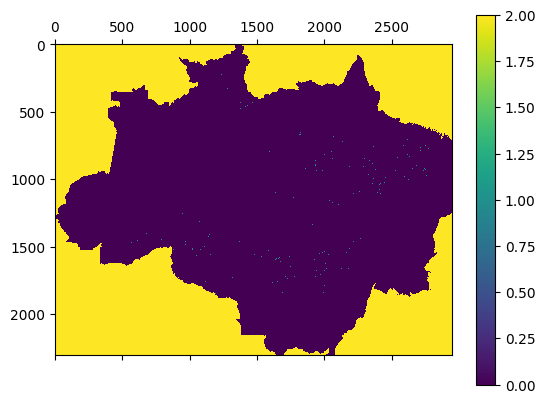

In [73]:
import matplotlib.pyplot as plt

img_test = load_tif_image(tif_path)
# Define the dimensions and create the result_array as shown previously

# Create a figure and axis for the plot
fig, ax = plt.subplots()
cax = ax.matshow(img_test_rec2[-1], cmap='viridis')
# cax = ax.matshow(img_test[-4], cmap='viridis')

# Add a colorbar for reference
cbar = plt.colorbar(cax)

# Show the plot
plt.show()

In [98]:
folder_path = Path('/home/thiago/AmazonDeforestation_Prediction/OpenSTL/data/Dataset/Gifs')
gif_file = folder_path / 'img_test_check.gif'
print("Saving GIF file")
# with imageio.get_writer(gif_file, mode="I", fps = 1) as writer:
with imageio.get_writer(gif_file, mode="I", duration = 1) as writer:
    for idx, frame in enumerate(img_test_rec2):
        print("Adding frame to GIF file: ", idx + 1)
        writer.append_data(frame*255)

Saving GIF file
Adding frame to GIF file:  1
Adding frame to GIF file:  2
Adding frame to GIF file:  3
Adding frame to GIF file:  4
Adding frame to GIF file:  5
Adding frame to GIF file:  6
Adding frame to GIF file:  7


# Reconstruct preds

In [26]:
def apply_legal_amazon_mask(input_image: np.array, amazon_mask: np.array):
    ''' Apply Legal Amazon mask '''
    print('DEBUG apply_legal_amazon_mask')
    for i in range(input_image.shape[0]):
        print(input_image.max(), input_image.min())
        input_image[i, :, :][amazon_mask == 2.0] = 2
        print(input_image.max(), input_image.min())
    return input_image

def load_tif_image(tif_path):
    gdal_header = gdal.Open(str(tif_path))
    return gdal_header.ReadAsArray()

mask_path = '/home/thiago/AmazonDeforestation_Prediction/AmazonData/Dataset_Felipe/area.tif'
mask = load_tif_image(mask_path)
mask[mask == 0.0] = 2.0
mask[mask == 1] = 0.0
print(mask.shape)

(2332, 3004)


In [42]:
import torch
# work_dir_path = '/home/thiago/AmazonDeforestation_Prediction/OpenSTL/work_dirs/custom_exp4/saved/preds.npy'
work_dir_path = Path('/home/thiago/AmazonDeforestation_Prediction/OpenSTL/work_dirs/custom_exp8/saved')

_preds = np.load(work_dir_path / 'preds.npy')

print(_preds.max(), _preds.min())
print(_preds.shape)
preds0 = F.log_softmax(torch.Tensor(_preds[:, :, 0])).numpy()
preds1 = F.log_softmax(torch.Tensor(_preds[:, :, 1])).numpy()
print(preds0.max(), preds1.min())

# argmax_preds = np.argmax(_preds, axis=2)
argmax_preds = np.argmax(F.log_softmax(torch.Tensor(_preds)).numpy(), axis=2)

original_shape = (11, 2368, 3008)
img_rec0 = patches_reconstruction2(preds0.reshape(-1, 7, 1, 64, 64), 64, original_shape)
print(img_rec0.shape)
img_rec0 = img_rec0[:, :mask.shape[0], :mask.shape[1]]
print(img_rec0.shape)
img_rec0 = apply_legal_amazon_mask(img_rec0, mask)
# print(img_rec.max(), img_rec.min())

img_rec1 = patches_reconstruction2(preds1.reshape(-1, 7, 1, 64, 64), 64, original_shape)
print(img_rec1.shape)
img_rec1 = img_rec1[:, :mask.shape[0], :mask.shape[1]]
print(img_rec1.shape)
img_rec1 = apply_legal_amazon_mask(img_rec1, mask)

img_rec_argmax = patches_reconstruction2(argmax_preds.reshape(-1, 7, 1, 64, 64), 64, original_shape)
print(img_rec_argmax.shape)
img_rec_argmax = img_rec_argmax[:, :mask.shape[0], :mask.shape[1]]
print(img_rec_argmax.shape)
img_rec_argmax = apply_legal_amazon_mask(img_rec_argmax, mask)
# print(img_rec.max(), img_rec.min())

(12173, 1, 2, 64, 64)


/tmp/ipykernel_1339822/3775342126.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  preds0 = F.log_softmax(torch.Tensor(_preds[:, :, 0])).numpy()
/tmp/ipykernel_1339822/3775342126.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  preds1 = F.log_softmax(torch.Tensor(_preds[:, :, 1])).numpy()
/tmp/ipykernel_1339822/3775342126.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  argmax_preds = np.argmax(F.log_softmax(torch.Tensor(_preds)).numpy(), axis=2)


1739 1739
Reconstruction Done!
(7, 2368, 3008)
(7, 2332, 3004)
DEBUG apply_legal_amazon_mask
0.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
1739 1739
Reconstruction Done!
(7, 2368, 3008)
(7, 2332, 3004)
DEBUG apply_legal_amazon_mask
0.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
1739 1739
Reconstruction Done!
(7, 2368, 3008)
(7, 2332, 3004)
DEBUG apply_legal_amazon_mask
0.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0


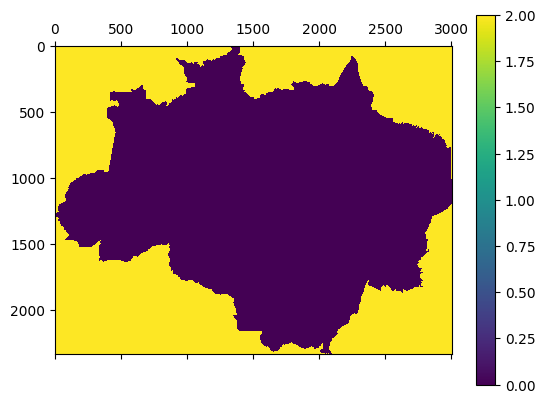

In [47]:
import matplotlib.pyplot as plt

# Create a figure and axis for the plot
fig, ax = plt.subplots()
cax = ax.matshow(img_rec_argmax[6], cmap='viridis')
# cax = ax.matshow(img_test[-4], cmap='viridis')

# Add a colorbar for reference
cbar = plt.colorbar(cax)

# Show the plot
plt.show()

In [48]:
# print(img_rec_argmax)
clss0 = np.sum(img_rec_argmax == 0)
clss1 = np.sum(img_rec_argmax == 1)
print(clss0 / (clss0 + clss1), clss1 / (clss0 + clss1))

1.0 0.0
40322646.0 8714650.0


(7, 2332, 3004) (7, 2332, 3004) (7, 2332, 3004)


MovieWriter imagemagick unavailable; using Pillow instead.


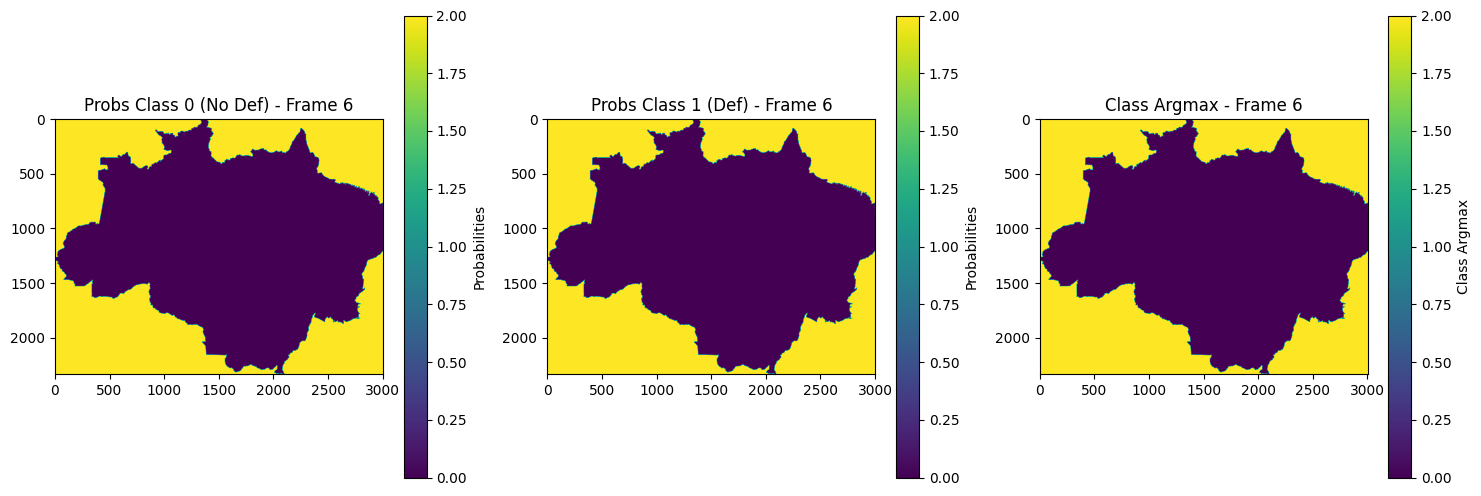

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

def plot_videos_side_by_side(video1, video2, video3, output_gif_path):
    # Determine the number of frames in the videos
    num_frames = min(video1.shape[0], video2.shape[0], video3.shape[0])

    # Create a figure and axis for the plot
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Create colorbars for each subplot
    cbar1 = fig.colorbar(ax[0].imshow(video1[0], cmap='viridis'), ax=ax[0])
    cbar2 = fig.colorbar(ax[1].imshow(video2[0], cmap='viridis'), ax=ax[1])
    cbar3 = fig.colorbar(ax[2].imshow(video3[0], cmap='viridis'), ax=ax[2])

    # Set color bar labels
    cbar1.set_label('Probabilities')
    cbar2.set_label('Probabilities')
    cbar3.set_label('Class Argmax')

    # Function to update the plot for each frame
    def update(frame):
        # Get frames from both videos
        frame1 = video1[frame]
        frame2 = video2[frame]
        frame3 = video3[frame]

        # Plot frames side by side
        ax[0].imshow(frame1, cmap='viridis')
        ax[1].imshow(frame2, cmap='viridis')
        ax[2].imshow(frame3, cmap='viridis')
        
        # Add titles to each subplot
        ax[0].set_title(f'Probs Class 0 (No Def) - Frame {frame}')
        ax[1].set_title(f'Probs Class 1 (Def) - Frame {frame}')
        ax[2].set_title(f'Class Argmax - Frame {frame}')

    # Create animation
    animation = FuncAnimation(fig, update, frames=num_frames, interval=100)

    # Save animation as gif
    animation.save(output_gif_path, writer='imagemagick', fps=1, dpi=300)

    # Display the plot (optional)
    plt.show()

# Example usage:
# Assuming video1 and video2 are numpy arrays representing the two videos
# video1 and video2 should have the shape (num_frames, height, width, channels)
# For example, if using RGB, channels = 3
# output_gif_path = 'output.gif'
output_gif_path = '/home/thiago/AmazonDeforestation_Prediction/OpenSTL/work_dirs/custom_exp8/saved/preds_probs.gif'

# # Replace video1_np and video2_np with your actual numpy arrays
# video1_np = np.random.rand(100, 240, 320, 3)  # Example random array
# video2_np = np.random.rand(100, 240, 320, 3)  # Example random array
print(img_rec0.shape, img_rec1.shape, img_rec_argmax.shape)

plot_videos_side_by_side(img_rec0, img_rec1, img_rec_argmax, output_gif_path)

In [3]:
# work_dir_path = '/home/thiago/AmazonDeforestation_Prediction/OpenSTL/work_dirs/custom_exp4/saved/preds.npy'
work_dir_path = Path('/home/thiago/AmazonDeforestation_Prediction/OpenSTL/work_dirs/custom_exp17/saved')

# _preds = np.load(work_dir_path / 'preds.npy')
# print(_preds.shape)
# preds0 = _preds[:, :, 0]
# preds1 = _preds[:, :, 1]

preds = np.argmax(np.load(work_dir_path / 'preds.npy'), axis=2)
trues = np.load(work_dir_path / 'trues.npy')
print(preds.max(), preds.min())

# print(preds)
print(preds.shape)
print(trues.shape)
original_shape = (11, 2368, 3008)
img_rec = patches_reconstruction2(preds.reshape(-1, 7, 1, 64, 64), 64, original_shape)
print(img_rec.shape)
img_rec = img_rec[:, :mask.shape[0], :mask.shape[1]]
print(img_rec.shape)
# img_rec = apply_legal_amazon_mask(img_rec, mask)
# print(img_rec.max(), img_rec.min())


folder_path = Path('/home/thiago/AmazonDeforestation_Prediction/OpenSTL/data/Dataset/Gifs')
gif_file = folder_path / 'img_test_trues.gif'
print("Saving GIF file")
# with imageio.get_writer(gif_file, mode="I", fps = 1) as writer:
with imageio.get_writer(gif_file, mode="I", duration=1) as writer:
    for idx, frame in enumerate(img_rec):
        print("Adding frame to GIF file: ", idx + 1)
        writer.append_data(frame*255)

(12173, 1, 2, 64, 64)


SyntaxError: 'break' outside loop (285534513.py, line 8)

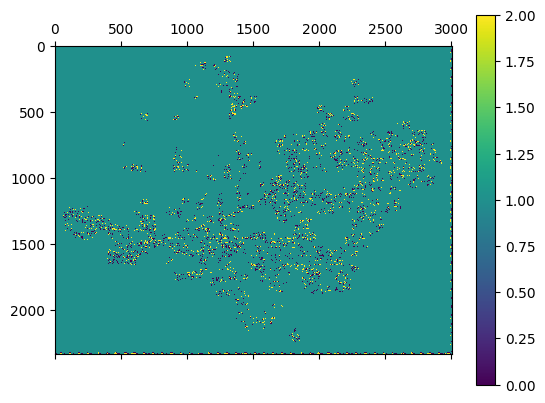

In [54]:
import matplotlib.pyplot as plt

# img_test = load_tif_image(tif_path)
# Define the dimensions and create the result_array as shown previously

# Create a figure and axis for the plot
fig, ax = plt.subplots()
cax = ax.matshow(img_rec[0], cmap='viridis')
# cax = ax.matshow(img_test[-4], cmap='viridis')

# Add a colorbar for reference
cbar = plt.colorbar(cax)

# Show the plot
plt.show()